# Evaluate

### Load test csv file

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format='retina'

test_data = pd.read_csv('./data/test_data_vector_complete.csv')
print(len(test_data))
test_data.head()

696


,title,image,ingredients,nutrients,file_name,parsed_ingredients,ingredient_vector,nutrient_vector
0,Buttery chilli prawns,https://images.immediate.co.uk/production/vola...,"['25g butter', '2 tbsp olive oil', '3 garlic c...","{'calories': '237 calories', 'fatContent': '22...",bread384.jpg,"['butter', 'olive oil', 'garlic clove', 'red c...","[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[237.0, 22.0, 8.0, 2.0, 1.0, 1.0, 9.0, 1.6]"
1,Sardine & asparagus traybake,https://images.immediate.co.uk/production/vola...,"['large bunch of asparagus', '1 olive & basil ...","{'calories': '700 calories', 'fatContent': '36...",bread386.jpg,"['asparagu', 'roll choice', 'olive oil', 'choo...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[700.0, 36.0, 8.0, 49.0, 5.0, 8.0, 40.0, 2.5]"
2,"Baked feta with peas, chilli & preserved lemon",https://images.immediate.co.uk/production/vola...,"['250g block of feta', '3 tbsp extra virgin ol...","{'calories': '541 calories', 'fatContent': '43...",bread387.jpg,"['block feta', 'olive oil', 'red chilli', 'lem...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[541.0, 43.0, 20.0, 12.0, 4.0, 4.0, 25.0, 3.1]"
3,Smoked salmon & quail’s egg,https://images.immediate.co.uk/production/vola...,"['6 quail eggs , at room temperature', '400g s...","{'calories': '327 calories', 'fatContent': '14...",bread388.jpg,"['quail egg', 'salmon', 'olive oil', 'slice ba...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[327.0, 14.0, 2.0, 31.0, 3.0, 2.0, 19.0, 3.4]"
4,Indian paneer skewers,https://images.immediate.co.uk/production/vola...,"['4 courgettes', '2 x 225g blocks paneer , eac...","{'calories': '557 calories', 'fatContent': '46...",bread389.jpg,"['courgette', 'block paneer', 'red pepper', 'r...","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[557.0, 46.0, 22.0, 8.0, 6.0, 3.0, 29.0, 0.1]"


### Load test images

In [2]:
# read test images using file_name column in the csv file

from PIL import Image

imgs = np.zeros((len(test_data),256,256,3))

for index, name in enumerate(test_data['file_name']):
    path = './data/test/' + name
    img = Image.open(path).resize((256, 256))
    if np.asarray(img).shape != (256,256,3):
        img = Image.open(path).convert('RGB').resize((256, 256))
    imgs[index] = img

imgs = imgs / 255.

### Plot training history

Text(0, 0.5, 'Loss')

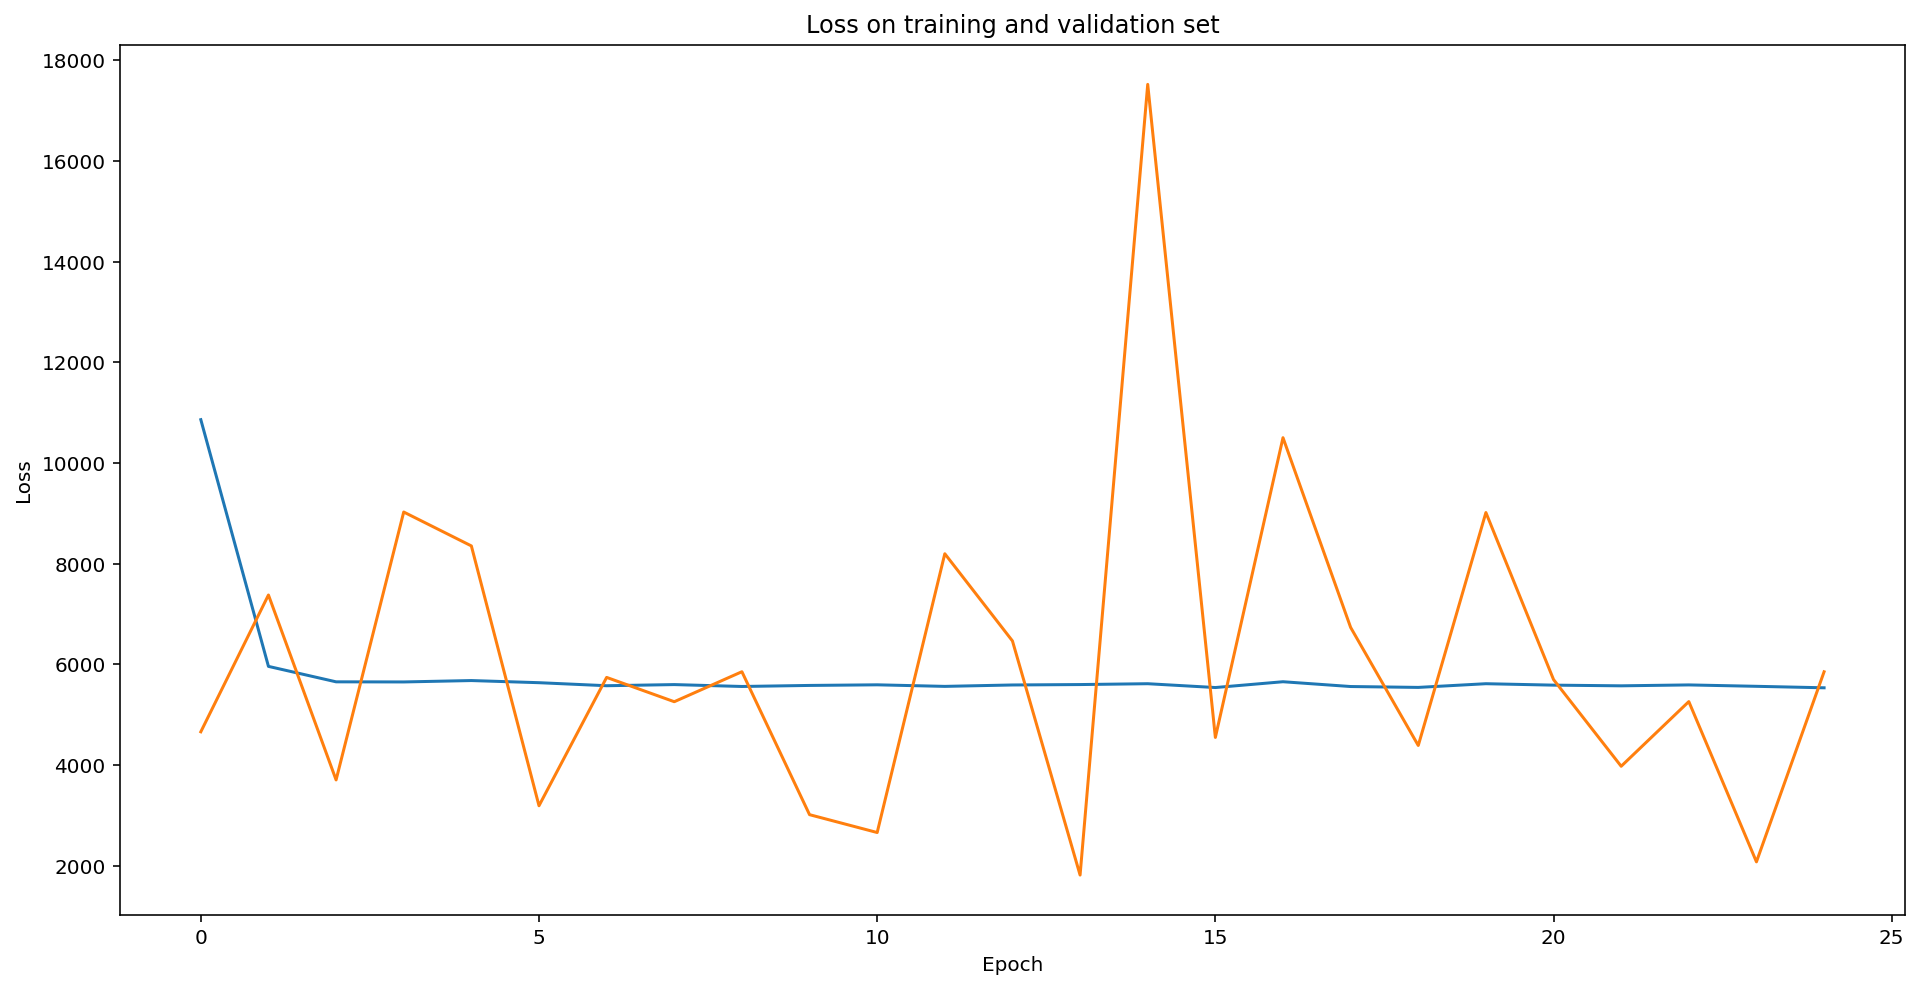

In [3]:
# plot server training curves

import pickle
import matplotlib.pyplot as plt

with open('./server/regression_256256_100_8_dataframe.pkl', 'rb') as f:
    history = pickle.load(f)
    

plt.figure(figsize=(16,8))
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')

plt.title("Loss on training and validation set")
plt.xlabel('Epoch')
plt.ylabel('Loss')

### Load model for evaluation

In [4]:
# load model

from keras.models import load_model

model = load_model('./server/regression_part.h5')

pred_nutrients = model.predict(imgs)
pred_nutrients.shape

(696, 8)

### Comparison between truth calories and predicted calories

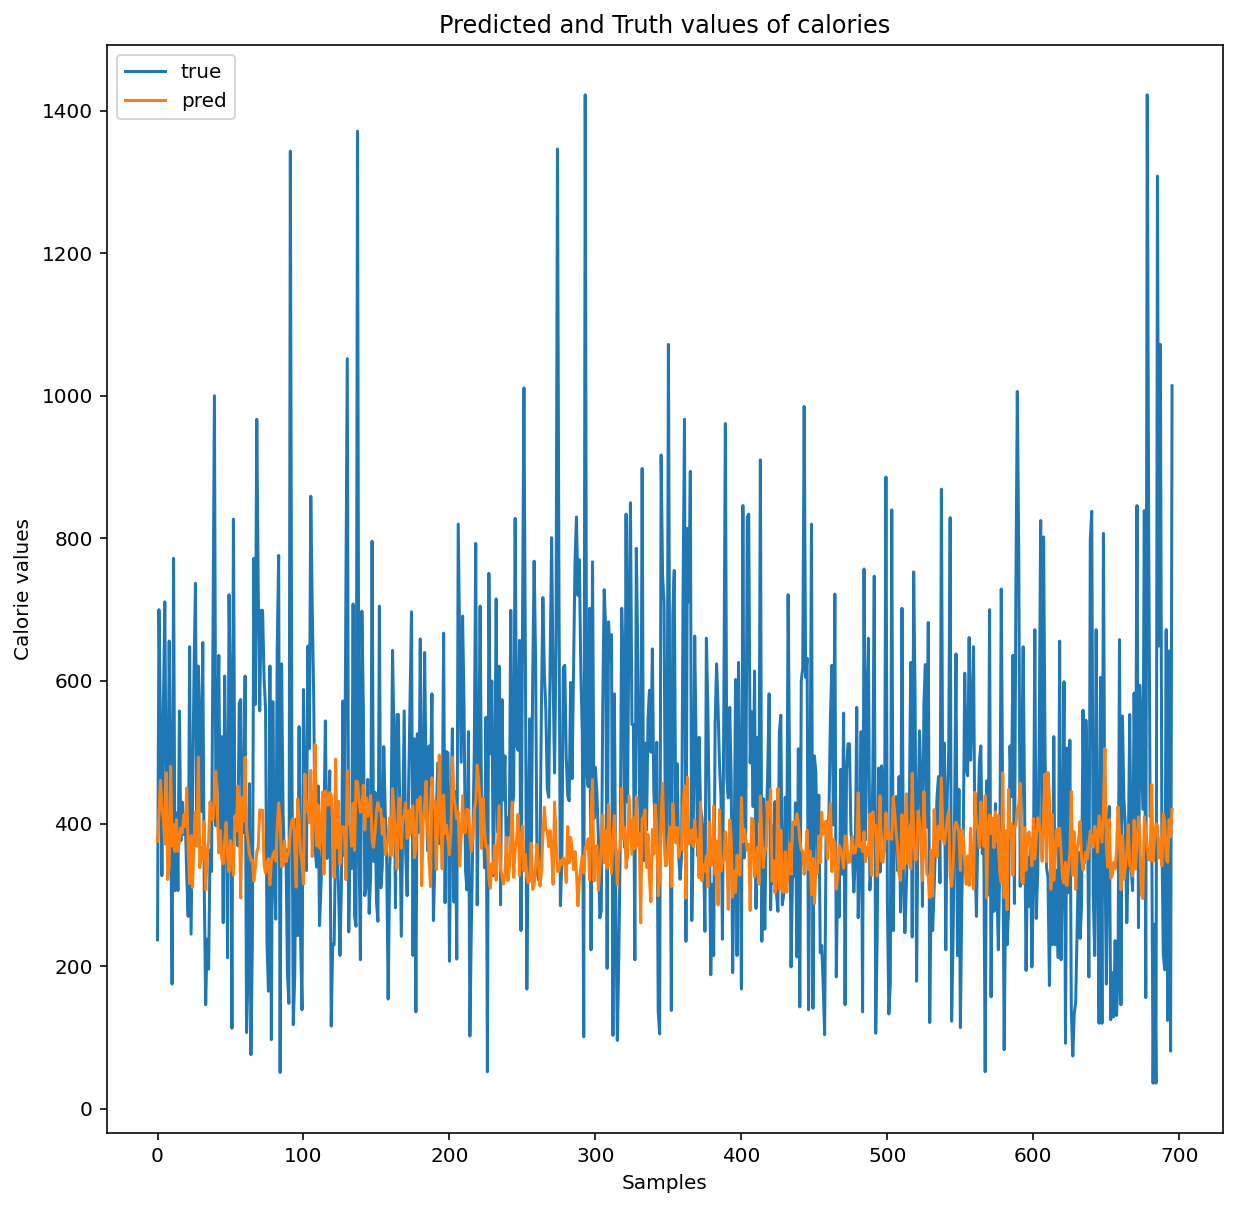

In [21]:
import ast

nutrient_information = [ast.literal_eval(i) for i in test_data['nutrient_vector']]

true_calories = [i[0] for i in nutrient_information]
pred_calories = [i[0] for i in pred_nutrients]

plt.figure(figsize=(10,10))

plt.title('Predicted and Truth values of calories')
plt.plot(true_calories, label='true')
plt.plot(pred_calories, label='pred')

plt.xlabel('Samples')
plt.ylabel('Calorie values')
plt.legend()

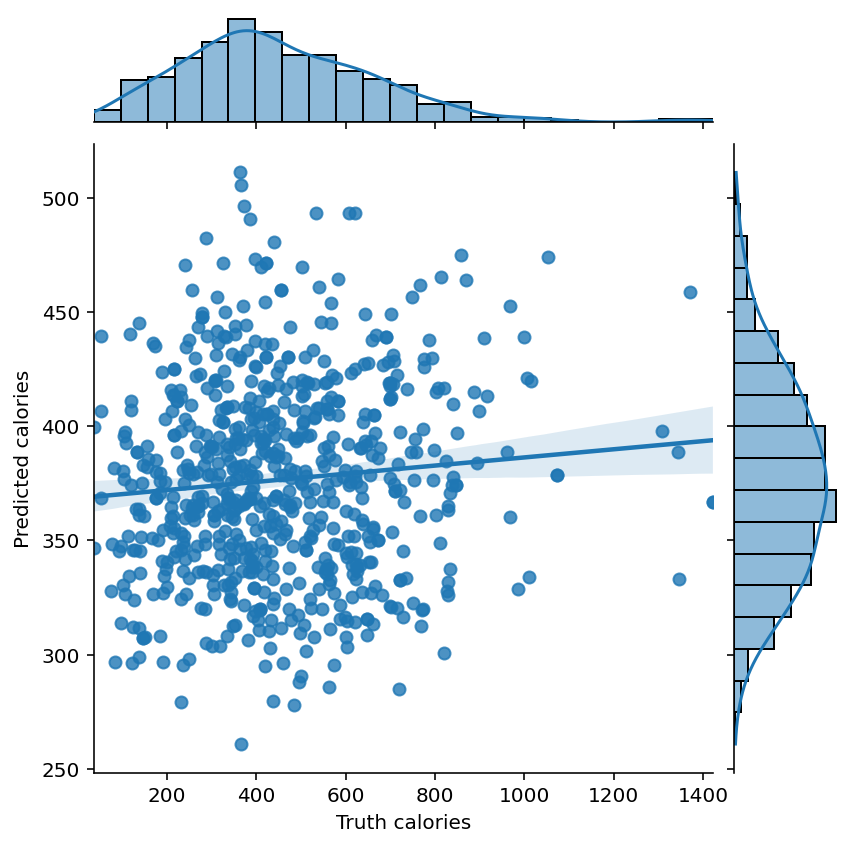

In [28]:
import seaborn as sns

calorie_table = pd.DataFrame(true_calories, columns=['Truth calories'])
calorie_table['Predicted calories'] = pred_calories
ax = sns.jointplot(x='Truth calories', y='Predicted calories', data=calorie_table, kind='reg')

In [29]:
calorie_table.describe()

,Truth calories,Predicted calories
count,696.000000,696.000000
mean,452.826149,376.547175
std,218.608510,43.282024
min,36.000000,260.847961
25%,306.000000,344.694977
50%,420.000000,375.412842
75%,582.000000,406.725021
max,1422.000000,511.055634


### Quantity evaluation of predicted calories

In [52]:
index = 10
print(true_calories[index])
print(pred_calories[index])

175.0
368.33325


In [43]:
calorie_error = [i-j for i, j in zip(true_calories, pred_calories)]
calorie_error[:5]

[-138.0794677734375,
 288.0789489746094,
 80.2618408203125,
 -97.34805297851562,
 149.465087890625]

In [54]:
abs_error = np.mean(np.abs(calorie_error))
rmse = np.sqrt(np.mean(np.square(calorie_error)))
mre = np.mean([i / j for i, j in zip(np.abs(calorie_error), true_calories)])

print("Mean absolute errors of calorie: ", abs_error, "kcal")
print("Root mean squared errors of calorie: ", rmse, "kcal")
print("Mean relative errors of calorie: ", mre, "%")

Mean absolute errors of calorie:  175.20107628833287 kcal
Root mean squared errors of calorie:  231.74810087851816 kcal
Mean relative errors of 8 nutrients:  0.5046423856240182 %


In [72]:
print("Sample number with relative error exceeds 50%: ", len([(a.index(i), i) for i in a if i>0.5]))
print("Sample number with relative error less than 50%: ", len([(a.index(i), i) for i in a if i<0.5]))

Sample number with relative error exceeds 50%:  182
Sample number with relative error less than 50%:  514


## Conclusion: the samples have large variation which the model cannot capture